**Author**: Lulof Pirée

**Date**: June 2022

--------------------------------------------------------------------------------
Copyright (C) 2022 Lulof Pirée

This file is part of the snakes_spn program.

This program is free software:
you can redistribute it and/or modify it under the terms
of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.
If not, see <https://www.gnu.org/licenses/>.

--------------------------------------------------------------------------------
## File content
Main experiment: influence of the following variables
on the amount of inflammation-repression:
* $x_1$: Initial concentration (amount of tokens) of GbPdn.
* $x_2$: Rate constant of GbPdn cleaving ($GbPdn+Gba2 \rightarrow Pdn + Gba2$).
* $x_3$: Rate constant of Gr* unbinding ($Gr^* \rightarrow Gr + Pdn$).
* $x_4$: Rate constant of GrGbPdn unbinding ($GrGbPdn \rightarrow Gr + GbPdn$).

In [1]:
from typing import Sequence

import os
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy import stats
import math
from numbers import Number

from spn_case_study.launch_experiment import (
    setup_init_markings_all_choices, setup_rates_all_choices)
from spn_case_study.run_grid_search import run_experiment, run_full_grid_search
from spn_case_study.petrinet import PLACES, VARS, TRANS, TRANS_TO_PLACES
from spn_tools.run_simulation import (plot_results, load_log,
    aggregate_dataset_in_timeboxes, get_num_timeboxes_for_fixed_duration)
import numpy as np

## Constants

In [2]:
INIT_TOKEN_COUNT = 1000
# Amount of independent repetitions per parameter setup
NUM_REPETITIONS = 50

# Maximum of discrete transition-firings per simulation run
MAX_NUM_TRANSITIONS = 10000
# Maximum amount of simulated time passed before simulation is terminated
MAX_TIME_PASSED = 0.005

## Directory structure

All files should be saved into `main_exp_data`.
This contains 3 subdirectories:
* `const_unbind_rates`: for experiments that fix $x_3$ and $x_4$,
    but try many different values for $x_1$ and $x_2$.
    Contains, for each value $x_3 = CCCC$ 
    and each value of $x_4 = DDDD$
    a subdirectory `x3_CCCC__x4_DDDD`.
    Each such subdirecory contains a directory
    for each variation of $x_1 = AAAA$ and $x_2 = BBBB$,
    e.g., `x1_123e-4__x2_321e-2`.
* `vary_unbind_rates`: same as `const_unbind_rates`,
    but with $(x_3, x_4)$ swapped with $(x_1, x_2)$.
* `baseline`: for the single experiment that has $x_1=x_2=x_3=x_4=0$.
    Used an unrepressed inflammation baseline 
    to assess strength of inflammation-repression.

```
main_exp_data/

    const_unbind_rates/
        x3_CCCC__x4_DDDD/
            x1_AAAA__x2_BBBB/
                logs.json
                hyperparameters.json
            .../
        .../

    vary_unbind_rates/
        x1_AAAA__x2_BBBB/
            x3_CCCC__x4_DDDD/
                logs.json
                hyperparameters.json
            .../
        .../

    baseline/
        logs.json
        hyperparameters.json
```

In [3]:
MAIN_DIR_NAME = "main_exp_dir"
CONST_UNBIND_DIR_NAME = "const_unbind_rates"
VARYING_UNBIND_DIR_NAME = "vary_unbind_rates"
BASELINE_DIR_NAME = "baseline"

# Notebooks usually set the cwd to the directory containing the notebook itself.
print(f"Current directory: {os.getcwd()}")
if "main_experiment.ipynb" in os.listdir(os.getcwd()):
    MAIN_SAVE_DIR = os.path.join(os.getcwd(), MAIN_DIR_NAME)
else:
    raise RuntimeError("Wrong working directory.")

CONST_UNBIND_SAVE_DIR = os.path.join(MAIN_SAVE_DIR, CONST_UNBIND_DIR_NAME)
VARYING_UNBIND_SAVE_DIR = os.path.join(MAIN_SAVE_DIR, VARYING_UNBIND_DIR_NAME)
BASELINE_SAVE_DIR = os.path.join(MAIN_DIR_NAME, BASELINE_DIR_NAME)

all_subdirs = [CONST_UNBIND_SAVE_DIR, VARYING_UNBIND_SAVE_DIR,
                BASELINE_SAVE_DIR]
for dir_name in all_subdirs:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

Current directory: /home/nifrec/Vault/Documents/master_1/bio_modelling/model_ass/snakes_spn/spn_case_study


## Baseline experiment

Data for experiment 'main_exp_dir/baseline' already exists.


[Text(0, 0.5, 'Neutrophil concentration'),
 Text(0.5, 1.0, 'Neutrophil recruitment without repression')]

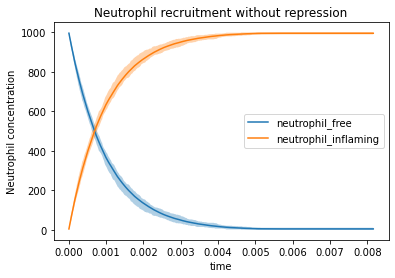

In [4]:
def check_experiment_already_done(dirname: str) -> bool:
    """
    Return whether is already a data-file of experimental data
    (a `logs.json` file) in the given directory.
    """
    dir_contents = os.listdir(dirname)
    if "logs.json" in dir_contents:
        print(f"Data for experiment '{dirname}' already exists.")
        return True
    return False

if not check_experiment_already_done(BASELINE_SAVE_DIR):
    init_markings = {name: (0,) for name in PLACES}
    init_markings["neutrophil_free"] = (INIT_TOKEN_COUNT,)
    init_markings["infl_sig"] = (INIT_TOKEN_COUNT,)

    rates = {name : "0" for name in TRANS}
    rates["recruit_neutrophil"] = f"{VARS['infl_sig']}*{VARS['neutrophil_free']}"

    run_experiment(rates, init_markings, BASELINE_SAVE_DIR, NUM_REPETITIONS, 
                        max_steps=MAX_NUM_TRANSITIONS, max_time=MAX_TIME_PASSED)


BASELINE_LOGS = load_log(os.path.join(BASELINE_SAVE_DIR, "logs.json"))
BASELINE_NUM_TIMEBOXES = 500
DESIRED_TIMEBOX_DURATION = MAX_TIME_PASSED/BASELINE_NUM_TIMEBOXES
num_timeboxes = get_num_timeboxes_for_fixed_duration(BASELINE_LOGS, 
                                        DESIRED_TIMEBOX_DURATION)
x_var = "time"
y_vars = ["neutrophil_free", "neutrophil_inflaming"]
ax = plot_results(BASELINE_LOGS, x_var, y_vars, 
             num_timeboxes, interval_type="min_max")
ax.set(ylabel="Neutrophil concentration",
    title="Neutrophil recruitment without repression")

### Comparison point
So judge the strength of inflammation-repression,
it is only fair to measure the inflammation strength
after **a fixes amount of simulated time passed**.
Fix this time to be the time after which half
the neutrophils have been recruited in the unrepressed case:

In [8]:
baseline_neutrophil_means, timebox_duration = \
    aggregate_dataset_in_timeboxes(BASELINE_LOGS, x_var="time",
        y_vars=["neutrophil_inflaming"], 
        num_timeboxes=BASELINE_NUM_TIMEBOXES)
baseline_neutrophil_means = \
    np.mean(baseline_neutrophil_means["neutrophil_inflaming"], axis=0)
i = 0
while baseline_neutrophil_means[i] < INIT_TOKEN_COUNT//2:
    i+=1
COMPARISON_TIMESTAMP = timebox_duration*i
print(COMPARISON_TIMESTAMP)

0.0006859455823488908


## First experiment: $x_3, x_4$ fixed

Values to try:
* $x_1 \in [10, 100, 1000, 2000, 3000] = [GbPdn]$
* $x_2 \in [0.001, 0.01, 1, 10, 100] = $ `CLEAVE_CONST`

In [5]:
# The ratio PDN_BIND_CONST-GBPDN_BIND_CONST is of interest.
# the absolute values would seem less relevant -- so fix this at 1:
PDN_BIND_CONST = 1
# It is given by the case-study provider that it is a 1000 times lower.
GBPDN_BIND_CONST = PDN_BIND_CONST/1000
# See the experiment `tune_inflam_repress_rate.ipynb`
# for the tuning of the inflammation-repression rate constant:
REPRESS_INFL_CONST = 10 
# Was fixed to this value while tuning the above:
NEUTROPHIL_RECRUIT_CONST = 1
CLEAVE_CONST = (0.001, 0.01, 1, 10, 100)

def setup_init_markings() -> dict[str, Sequence[int]]:
    init_markings = {name: (0,) for name in PLACES}
    init_markings["gba2"] = (1000,)
    init_markings["gbpdn"] = (10, 100, 1000, 2000, 3000)
    init_markings["neutrophil_free"] = (1000,)
    init_markings["gr_free"] = (1000,)
    init_markings["infl_sig"] = (1000,)
    return init_markings

def setup_rates() -> dict[str, Sequence[str]]:
    rates = {trans_name : ("0",) for trans_name in TRANS}
    rates["cleave"] = [
        f"{cleave_rate}*{VARS['gba2']}*{VARS['gbpdn']}"
        for cleave_rate in CLEAVE_CONST]

    # Binding -- Mass Action
    rates["bind_pdn"] = (f"{PDN_BIND_CONST}*{VARS['pdn']}*{VARS['gr_free']}",)
    rates["bind_gbpdn"] = (f"{GBPDN_BIND_CONST}*{VARS['gbpdn']}*{VARS['gr_free']}",)

    rates["repress_infl"] = (f"{REPRESS_INFL_CONST} * {VARS['gr_pdn']}",)
    rates["recruit_neutrophil"] = (f"{NEUTROPHIL_RECRUIT_CONST}*"
        + f"{VARS['neutrophil_free']}*{VARS['infl_sig']}",        
    )
    return rates

In [6]:
subdir_name = "x3_0__x4_0"
subdir_path = os.path.join(CONST_UNBIND_SAVE_DIR, subdir_name)
if not os.path.exists(subdir_path):
    os.mkdir(subdir_path)

if not os.path.exists(os.path.join(subdir_path, "exp_0")):
    run_full_grid_search(setup_rates(), setup_init_markings(), subdir_path, 
                        NUM_REPETITIONS, max_steps=MAX_NUM_TRANSITIONS, 
                        max_time=MAX_TIME_PASSED)

Starting experiment 0


FileExistsError: [Errno 17] File exists: '/home/nifrec/Vault/Documents/master_1/bio_modelling/model_ass/snakes_spn/spn_case_study/main_exp_dir/const_unbind_rates/x3_0__x4_0/exp_0'